# 0. Imports

In [1]:
# from pandas_profiling import ProfileReport
# from ydata_profiling import ProfileReport

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random, os
import plotly.express as px
import re
from IPython.display import HTML, Image
import matplotlib.font_manager
import matplotlib.cm as cm
from datetime import datetime


# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import product

# Models
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans, AgglomerativeClustering, MeanShift
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

# Visualização de clusters
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score, fowlkes_mallows_score
import umap.umap_ as umap

from scipy.cluster import hierarchy as hc
from scipy.cluster.hierarchy import dendrogram, linkage

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Warnings
import warnings
warnings.filterwarnings('ignore')

/home/leassis/repos/portfolio/allmart/.venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/leassis/repos/portfolio/allmart/.venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/leassis/repos/portfolio/allmart/.venv/lib/python

In [2]:
# !uv pip install "numpy<2.0"

In [2]:
!uv pip check

Using Python 3.9.21 environment at: /home/leassis/repos/portfolio/allmart/.venv
Checked 195 packages in 8ms
All installed packages are compatible


In [3]:
def jupyter_settings():
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 15

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    color_pal = sns.color_palette()
    plt.style.use('ggplot')
    sns.set()
jupyter_settings()

## 0.2 CFG

In [4]:
class CFG:
    FOLDS = 5
    seed = 42
    TARGET = ''
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

# 1.0 Data Reading

## 1.1 Data Loading

In [5]:
df1 = pd.read_csv('../data/01_raw/Ecommerce.csv', encoding='unicode_escape')
df1.drop(columns=['Unnamed: 8'], axis=1, inplace=True)
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.2 Data Dimensions

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3 Data Dtypes

In [7]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4 Checking NA

In [8]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 2.0 Data Wrangling

In [9]:
df2 = df1.copy()

## 2.1 Rename Columns

In [10]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df2.columns = cols_new

## 2.2 Replacing NAs

In [11]:
df_missing = df2.loc[df2['customer_id'].isna(), :]
df_not_missing = df2.loc[~df2['customer_id'].isna(), :]

In [12]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


In [13]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)


# merge original with reference dataframe
df2 = pd.merge(df2, df_backup, on='invoice_no', how='left')

# coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first(df2['customer_id_y'])

# drop extra columns
df2 = df2.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [14]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [15]:
df2.dropna(subset=['description', 'customer_id'], inplace=True)
print(f'Removed data: {1-(df2.shape[0]/df1.shape[0]):.2f}')

Removed data: 0.00


In [16]:
df2.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 2.3 Changing Dtypes

In [17]:
# Invoice Date
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# Customer ID
df2['customer_id'] = df2['customer_id'].astype(int)

In [18]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 2.4 Drop Duplicates

In [19]:
# Create DataFrame Reference

df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## 2.5 Descriptive Statistics

### 2.5.1. Numerical Features

In [20]:
num_cols = df2.select_dtypes(include=['number'])
cat_cols = df2.select_dtypes(exclude=['number', 'datetime64[ns]'])

In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_cols.apply(np.mean)).T
ct2 = pd.DataFrame(num_cols.apply(np.median)).T


#  Dispersion - Desvio Padrão, minimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_cols.apply(np.std)).T
d2 = pd.DataFrame(num_cols.apply(np.min)).T
d3 = pd.DataFrame(num_cols.apply(np.max)).T
d4 = pd.DataFrame(num_cols.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_cols.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_cols.apply(lambda x: x.kurtosis())).T

# Concat
descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
descriptive

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.60,3.00,218.01,-0.28,120252.45
1,unit_price,-11062.06,38970.00,50032.06,4.62,2.08,96.89,186.26,58848.02
2,customer_id,12346.00,22709.00,10363.00,16678.15,16241.00,2907.57,0.49,-0.79


Investigar:
1. Quantidade negativa: pode significar "devolução"
2. Preço unitário igual a zero: pode ser promoção


### 2.5.1. Categorical Features

#### Invoice No
Problema: detectamos que Invoice_no apresenta letras além de números. Precisamos converter para inteiro.

In [22]:
df_invoices_cat = cat_cols.loc[cat_cols['invoice_no'].apply(lambda x: bool(re.search('[^0-9+]', x))), 'invoice_no']

# o regex acima procura necessariamente por CARACTERES != de numeros (^) sendo 1 ou mais caracteres.

print(f'Número total de transações: {df_invoices_cat.shape[0]}')
print(f'Número total de quantidades negativas: {df2.loc[df2["quantity"] < 0].shape[0]}')

Número total de transações: 9291
Número total de quantidades negativas: 9762


Podemos assumir que quando há uma letra no "invoice_no" significa que esta transação foi retornada ou cancelada. A letra "C" provalmente é um indicativo de _charge back_ ("estorno", em inglês).

#### Stock Code
Não sabemos o que significam essas siglas, por isso iremos removê-las nesse primeiro momento.

In [23]:
# Stock Code

cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# O regex acima procura por strings que DEVEM começar com uma letra(^), e DEVEM terminar ($) com uma letra OU MAIS (+)

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description
Iremos também deletar a variável description, por não apresentar informações relevantes neste primeiro momento.

In [24]:
df2['description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

#### Country
Uma das formas de avaliar uma região, é observar o quão representativo cada uma delas é em nosso dataset. Vamos observar a seguir:

In [25]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [26]:
df2['country'].value_counts(normalize=True).reset_index().head(10)

,country,proportion
0,United Kingdom,0.91
1,Germany,0.02
2,France,0.02
3,EIRE,0.02
4,Spain,0.00
5,Netherlands,0.00
6,Belgium,0.00
7,Switzerland,0.00
8,Portugal,0.00
9,Australia,0.00


Podemos visualizar também a quantidade de clientes únicos por país. Vamos visualizar os 10 países com mais clientes:

In [27]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).head(10)

,country,customer_id
36,United Kingdom,6133
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


Os 10 países com menos clientes:

In [28]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).tail(10)

,country,customer_id
35,United Arab Emirates,2
8,Czech Republic,1
22,Lithuania,1
11,European Community,1
21,Lebanon,1
28,RSA,1
29,Saudi Arabia,1
30,Singapore,1
17,Iceland,1
4,Brazil,1


In [29]:
print(df2['quantity'].min(), df2['quantity'].max())
print(df2[df2['quantity'] < 0].shape)
print(df2[df2['quantity'] > 0].shape)
print(df2[df2['quantity'] == 0].shape)
print(df2.shape)

-80995 80995
(9762, 8)
(530693, 8)
(0, 8)
(540455, 8)


In [30]:
df2_country_count = df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).rename(columns={'customer_id':'qt_customers'})

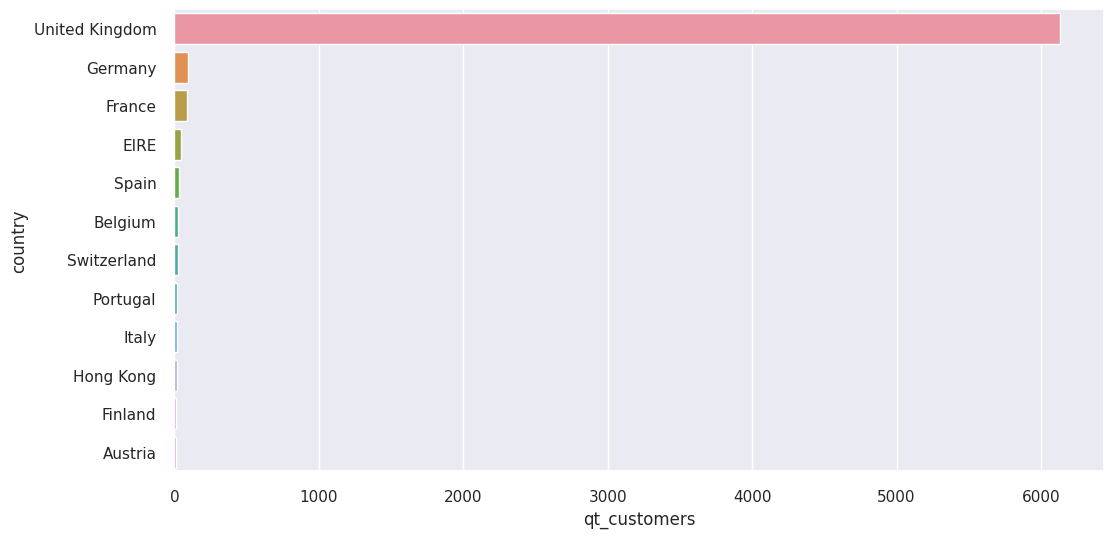

In [31]:
sns.barplot(data=df2_country_count[df2_country_count['qt_customers'] > 10], x='qt_customers', y='country');

Seguiremos as análises filtrando apenas os clientes do Reino Unido ("United Kingdom"), pela discrepância em relação a todo o resto.

# 3.0 Feature Filtering

Aqui tomaremos as ações decididas na seção anterior para selecionar da melhor forma as nossas features para análise.

In [32]:
df3 = df2.copy()

In [33]:
###### Numerical Cols ######
df3 = df3.loc[df3['unit_price'] > 0.04, :]


###### Categorical Cols ######
df3 = df3.loc[~df3['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


# Description
df3 = df3.drop(columns='description', axis=1)


# Map
df3 = df3[df3['country'].isin(['United Kingdom'])]
# df3 = df3[~df3['country'].isin(['European Community', 'Unspecified'])]


# Bad Users - Atualizado após Análise Univariada
df3 = df3[~df3['customer_id'].isin([16464])]

# Quantity - negative numbers means product returns
df3_returns = df3.loc[df3['quantity'] < 0, :]
df3_purchases = df3.loc[df3['quantity'] > 0, :]


# 4.0 Feature Engineering

- Algumas ideias:
    
    - Moving average: 7d, 14d, 30d
    - Quantidade de compras por mês: antes do dia 15 e depois do 15;
    - Average Financial
    - Basket Size * Price: Quantidade de preços por cesta
    


In [34]:
df3_returns.shape, df3_purchases.shape, df3.shape

((7387, 7), (483761, 7), (491148, 7))

In [35]:
df4 = df3.copy()

In [36]:
# data reference
df_ref = df4.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [37]:
def create_features(df):
    """
    Adds features to train set.   
    """
    
    df_ref = df.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)    
    
    # Gross Revenue (Faturamento = Quantidade * Preço)
    df['gross_revenue'] = df['quantity'] * df['unit_price']
    # Monetary
    df_monetary = df.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index().copy()
    
    
    # Recency: Dia da última compra
    df_recency = df.groupby('customer_id')['invoice_date'].max().reset_index()
    df_recency['recency'] = (df['invoice_date'].max() - df_recency['invoice_date']).dt.days
    df_recency = df_recency[['customer_id', 'recency']].copy()
    
    
    # Frequency - Contagem do número de compras feitas pelo cliente
    df_freq = (df[['customer_id', 'invoice_no']].drop_duplicates()
                                                          .groupby('customer_id')
                                                          .count()
                                                          .reset_index()
                                                          .astype(int)
                                                          .rename(columns={'invoice_no':'frequency'}))
    
    # Freq Quantity items
    df_freq2 = (df[['customer_id', 'quantity']].groupby('customer_id').sum()
                                                    .reset_index()
                                                    .rename(columns={'quantity':'qtde_items'}))
    
    df_freq3 = (df[['customer_id', 'stock_code']].groupby('customer_id').count()
                                                .reset_index()
                                                .rename(columns={'stock_code':'qtde_products'}))
    
    # Avg Ticket - Ticket Médio
    df_avg_ticket = (df[['customer_id', 'gross_revenue']].groupby('customer_id')
                                                         .mean()
                                                         .reset_index()
                                                         .rename(columns={'gross_revenue':'avg_ticket'}))


    df_aux49 = (df.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id') \
                                                                              .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('quantity', 'sum')) \
                                                                              .reset_index())
    serie_49 = df_aux49['n_products'] / df_aux49['n_purchase']
    df_aux49['avg_basket_size'] = serie_49

    df_aux410 = (df.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id') \
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('stock_code', 'nunique')) \
                                                                          .reset_index())
    serie_410 = df_aux410['n_products'] / df_aux410['n_purchase']
    df_aux410['avg_unique_basket_size'] = serie_410

    
    df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_freq2, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_freq3, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
    df_ref = pd.merge(df_ref, df_aux49[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_aux410[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
    
    df_ref.rename(columns={'gross_revenue':'monetary',
    #                'invoice_no':'quantity'
                          },
                    inplace=True)
    
    
    return df_ref

In [38]:
df_ref = create_features(df4)

# 5.0 Pipeline Structure: Feature Normalization, Space Creation, Model Selection

In [95]:
X = df_ref.copy()

In [96]:
X_train = X.drop(columns='customer_id', axis=1)

## 5.1 PCA Optimal Number 

The optimal number of PCA's is: 8


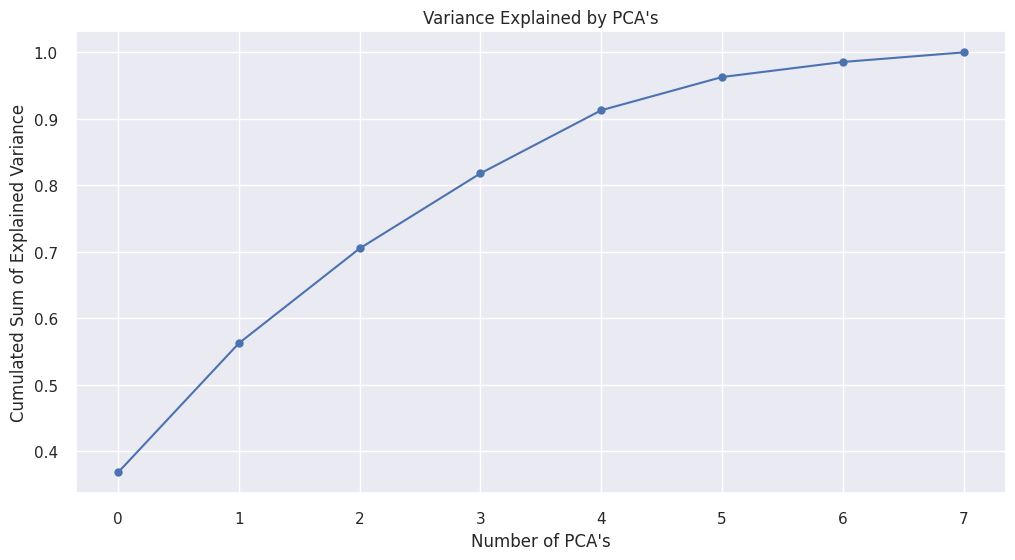

In [50]:
# CROSS VALIDATED - 08/02/2025

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Find the optimal number of PCA 
pca = PCA(n_components=X_train_scaled.shape[1])
pca.fit(X_train_scaled)
ratios = pca.explained_variance_ratio_

# Plot the explained variance ratios
x = np.arange(X_train_scaled.shape[1])
plt.plot(x, np.cumsum(ratios), '-o')
plt.xlabel("Number of PCA's")
plt.ylabel("Cumulated Sum of Explained Variance")
plt.title("Variance Explained by PCA's")

# Find the optimal number of PCA's
for i in range(np.cumsum(ratios).shape[0]):
    if np.cumsum(ratios)[i] >= 0.99:
        num_pca = i + 1
        print ("The optimal number of PCA's is: {}".format(num_pca))
        break
    else:

        continue

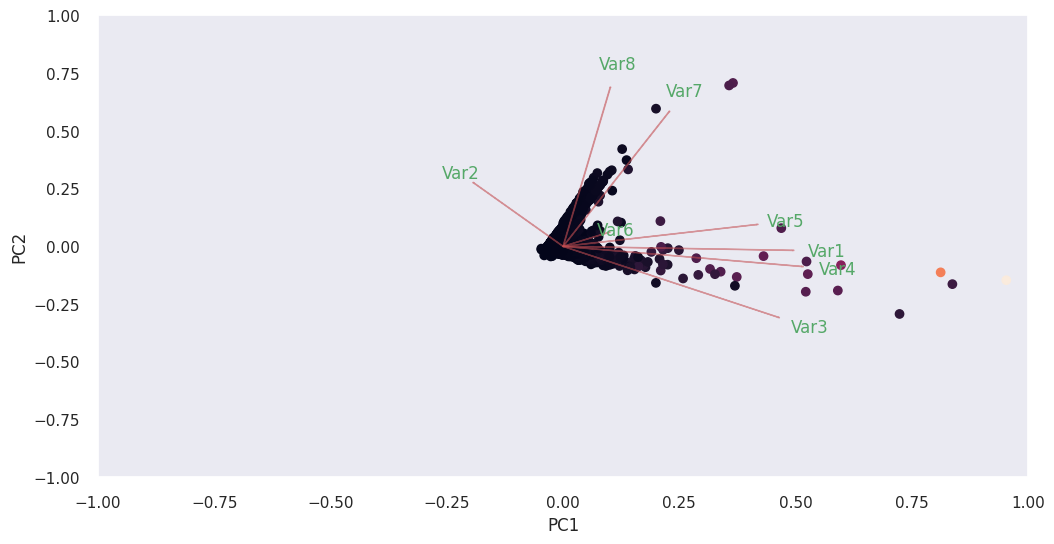

In [68]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = X_train['monetary'])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()

PC1 explica 36.8% e PC2 19.4%.

Aqui, `pca.components_` tem as dimensões: [n_components, n_features]. Assim, olhando para o PC1, cuja linha é [[0.49257252 0.1917196  0.46215589 0.5126115  0.4154446  0.0977349  0.22774491 0.10120875]], podemos concluir que as features 1, 3, 4 e 5 são as mais importantes. Isso também fica claramente visível no biplot (é por isso que frequentemente usamos esse gráfico para resumir as informações de forma visual).

Para resumir, podemos obseravr os valores absolutos dos componentes dos Autovetores correspondentes aos k maiores Autovalores. No sklearn, os componentes são classificados por `explained_variance_`. Quanto maiores forem esses valores absolutos, mais uma feature específica contribui para esse componente principal.

As features importantes são aquelas que influenciam mais os componentes e, portanto, têm um grande valor/pontuação absoluto no componente.

Para obtê-las nos PCs com nomes e salvá-los em um dataframe pandas, faremos isto:

In [91]:
pd.DataFrame(train_features, columns=X_train.columns)

,monetary,recency,frequency,qtde_items,qtde_products,avg_ticket,avg_basket_size,avg_unique_basket_size
0,0.55,0.69,0.65,0.22,0.71,0.24,0.33,0.75
1,0.65,0.85,0.66,0.57,0.09,0.37,0.27,0.24
2,0.97,0.39,0.89,0.63,0.79,0.50,0.58,0.49
3,0.20,0.72,0.28,0.02,0.65,0.18,0.94,0.95
4,0.91,0.37,0.02,0.93,0.43,0.97,0.96,0.85
5,0.29,0.39,0.85,0.32,0.17,0.56,0.94,0.70
6,0.57,0.10,0.62,0.99,0.14,0.52,0.88,0.74
7,0.70,0.70,0.36,0.29,0.81,0.81,0.87,0.91
8,0.51,0.50,0.80,0.65,0.70,0.80,0.89,0.34
9,0.38,0.09,0.58,0.04,0.47,0.54,0.29,0.59


In [84]:
train_features.shape

(10, 8)

In [100]:
def get_most_important_feature(X_train, X_train_scaled, model):

    # model = PCA(n_components=2).fit(train_features)
    X_pc = model.fit_transform(X_train_scaled)

    # number of components
    n_pcs= model.components_.shape[0]

    # get the index of the most important feature on EACH component
    # LIST COMPREHENSION HERE
    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

    # get the names
    initial_feature_names = X_train.columns
    assert len(X_train.columns) == pca.components_.shape[0], 'PCs not in the same shape of X columns'
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

    # LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    df = pd.DataFrame(dic.items())
    
    return df

In [101]:
features_imp = get_most_important_feature(X_train, X_train_scaled, pca)

In [102]:
features_imp

,0,1
0,PC0,qtde_items
1,PC1,avg_unique_basket_size
2,PC2,avg_ticket
3,PC3,recency
4,PC4,avg_ticket
5,PC5,avg_basket_size
6,PC6,frequency
7,PC7,qtde_items


## 5.2 Pipeline

In [39]:
class TreeBasedEmbedding(BaseEstimator, TransformerMixin):
    """
    Custom transformer that uses Random Forest's apply method to create tree-based embeddings.
    This always will only use 2 components.
    """
    def __init__(self, n_components=2, n_estimators=100, random_state=42):
        self.n_components = 2  # Hardcoded to 2 as per your original implementation
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.rf = None
        
    def fit(self, X, y=None):
        # Validate y
        if y is None:
            raise ValueError("A target variable is required for fitting")
        
        # Ensure y is a Series or can be converted to one
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        
        # Handle DataFrame or numpy array input
        if isinstance(X, pd.DataFrame):
            X_features = X.drop(columns=[y.name])
        else:
            X_features = X
        
        # Train a RandomForestRegressor
        self.rf = RandomForestRegressor(
            n_estimators=self.n_estimators,
            random_state=self.random_state
        )
        self.rf.fit(X_features, y)
        return self
    
    def transform(self, X):
        # Get leaf indices for each sample across all trees
        if self.rf is None:
            raise ValueError("Transformer not fitted. Call fit before transform.")
        
        # Handle DataFrame or numpy array input
        if isinstance(X, pd.DataFrame):
            X_features = X.values
        else:
            X_features = X
        
        leaf_indices = self.rf.apply(X_features)
        return leaf_indices
    
    def fit_transform(self, X, y):
        # Validate y
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        
        # Handle DataFrame or numpy array input
        if isinstance(X, pd.DataFrame):
            X_features = X.drop(columns=[y.name])
        else:
            X_features = X
        
        # Train a RandomForestRegressor
        self.rf = RandomForestRegressor(
            n_estimators=self.n_estimators,
            random_state=self.random_state
        )
        self.rf.fit(X_features, y)
        
        leaf_indices = self.rf.apply(X_features)
        return leaf_indices
    


def making_preds(X, y, component_range, cluster_range, eps_range, n_estimators=100):
    results = []
    best_pipeline = None
    best_score = -np.inf
    best_params = None

    scalers = {
        "StandardScaler": StandardScaler(),
        "MinMaxScaler": MinMaxScaler(),
        "RobustScaler": RobustScaler(),
    }
    
    reductors = {
        'PCA': PCA,  
        'UMAP': umap.UMAP, 
        'TreeBasedEmbedding': TreeBasedEmbedding, 
    }
    
    metrics = {
        "Silhouette Score": silhouette_score,
        "Calinski Harabasz Score": calinski_harabasz_score,
        "Davies Bouldin Score": davies_bouldin_score,
    }
    
    # Main loop
    for scaler_name, scaler in tqdm(scalers.items(), desc="Scalers"):
        for red_name, reductor in tqdm(reductors.items()):
            for model_name in tqdm(['DBSCAN', 'K-Means', 'Hierarchical', 'Gaussian Mixture']):
                if model_name == 'DBSCAN':
                    for component in component_range:
                        X_scaled = scaler.fit_transform(X)
                        
                        # Properly instantiate reductor
                        if red_name != 'TreeBasedEmbedding':
                            X_pca = reductor(n_components=component, random_state=42).fit_transform(X_scaled)
                        else:
                            X_leaf = reductor(n_estimators=n_estimators).fit_transform(X, y)
                            X_pca = PCA(n_components=2).fit_transform(X_leaf)
                        
                        for eps_val in eps_range:
                            model = DBSCAN(eps=eps_val, min_samples=20)
                            labels = model.fit_predict(X_pca)

                            # Calculate only if at least 5 clusters exist, removing noise
                            unique_labels = np.unique(labels)
                            unique_labels = unique_labels[unique_labels != -1]

                            if len(unique_labels) >= 5:
                                sil = silhouette_score(X, labels)
                                ch = calinski_harabasz_score(X, labels)
                                db = davies_bouldin_score(X, labels)

                                # Store results
                                results.append({
                                    'scaler': scaler_name,
                                    'dim_reduction': red_name,
                                    'n_components': component,
                                    'model': model,
                                    'n_clusters/eps': eps_val,
                                    'silhouette': sil,
                                    'calinski_harabasz': ch,
                                    'davies_bouldin': db,
#                                     'labels': labels
                                })
                else:
                    for component in component_range:
                        X_scaled = scaler.fit_transform(X)
                        
                        # Properly instantiate reductor
                        if red_name != 'TreeBasedEmbedding':
                            X_pca = reductor(n_components=component, random_state=42).fit_transform(X_scaled)
                        else:
                            X_leaf = reductor(n_estimators=n_estimators).fit_transform(X, y)
                            X_pca = PCA(n_components=2).fit_transform(X_leaf)
                        
                        for cluster in cluster_range:
                            if model_name == 'K-Means':
                                model = KMeans(n_clusters=cluster, random_state=42, n_init=20)
                            elif model_name == 'Hierarchical':
                                model = AgglomerativeClustering(n_clusters=cluster)
                            elif model_name == 'Gaussian Mixture':
                                model = GaussianMixture(n_components=cluster, random_state=42)
                            
                            labels = model.fit_predict(X_pca)
                            sil = silhouette_score(X, labels)
                            ch = calinski_harabasz_score(X, labels)
                            db = davies_bouldin_score(X, labels)
                            
                            results.append({
                                'scaler': scaler_name,
                                'dim_reduction': red_name,
                                'n_components': component,
                                'model': model,
                                'n_clusters/eps': cluster,
                                'silhouette': sil,
                                'calinski_harabasz': ch,
                                'davies_bouldin': db,
#                                 'labels': labels
                            })
                            
    results_no_pipeline = [{k: v for k, v in r.items() if k != 'pipeline' and k != 'labels'} for r in results]
    results_pd = pd.DataFrame(results_no_pipeline)
    best_result = results_pd.sort_values(['silhouette', 'calinski_harabasz', 'davies_bouldin'], ascending=[False, False, False])[0]
    return pd.DataFrame(results_no_pipeline)

In [40]:
comp_range = np.arange(2, 9)
clust_range = np.arange(5, 11)
eps_range = np.arange(0.2, 1.0, 0.1)

In [196]:
%%time

final_preds = making_preds(X=X_train, y=y, component_range=comp_range, cluster_range=clust_range, eps_range=eps_range)

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████▎                                                               | 1/4 [00:06<00:20,  6.72s/it]

 50%|██████████████████████████████████████████▌                                          | 2/4 [01:12<01:23, 41.62s/it]

 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [01:45<00:37, 37.47s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:19<00:00, 34.88s/it]

 33%|████████████████████████████                                                        | 1/3 [02:19<04:39, 139.50s/it]

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|███████████████████

CPU times: user 1h 6min 25s, sys: 1h 8min 19s, total: 2h 14min 44s
Wall time: 25min 55s


In [201]:
results_no_pipeline = [{k: v for k, v in r.items() if k != 'pipeline' and k != 'labels'} for r in final_preds]
final_preds_df = pd.DataFrame(results_no_pipeline)

In [208]:
final_preds_df.sort_values(['silhouette', 'calinski_harabasz', 'davies_bouldin'], ascending=[False, False, False]).head()

,scaler,dim_reduction,n_components,model,n_clusters/eps,silhouette,calinski_harabasz,davies_bouldin
872,RobustScaler,PCA,6,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.67,1446.53,1.57
848,RobustScaler,PCA,2,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.67,1440.64,1.60
878,RobustScaler,PCA,7,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.67,1479.89,1.64
850,RobustScaler,PCA,2,"KMeans(n_clusters=7, n_init=20, random_state=42)",7.00,0.64,5835.54,1.17
6,StandardScaler,PCA,3,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.57,1767.84,1.34


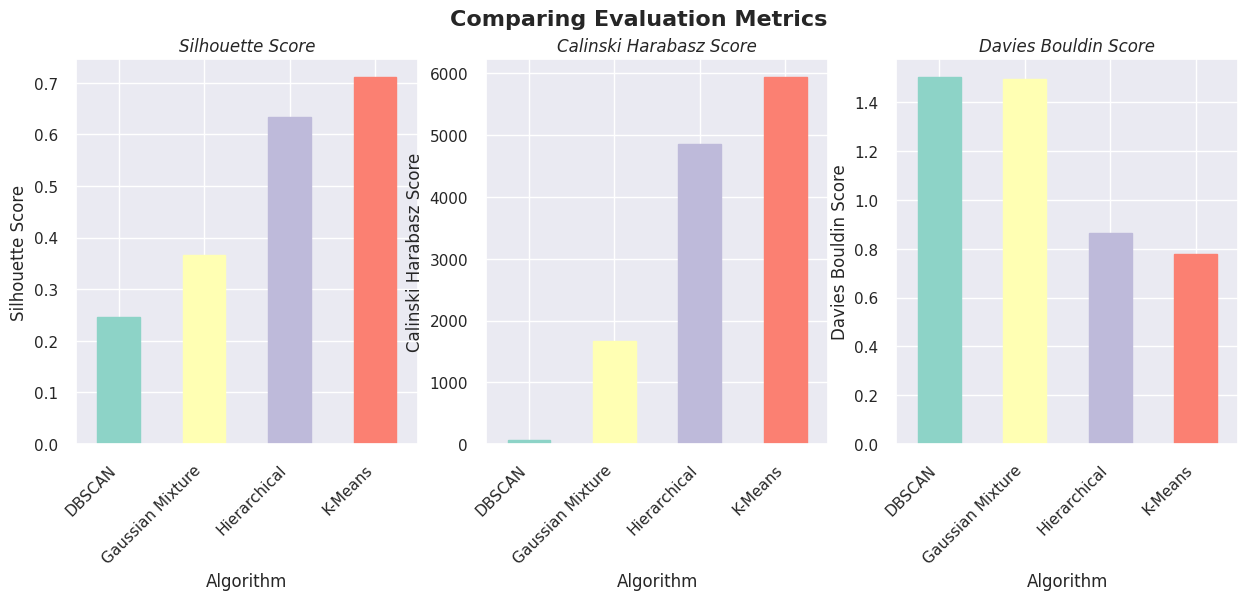

In [127]:
# Pivot the data to have algorithms as columns and metrics as rows
pivoted_df = pred_df.pivot_table(
    index="Metric", columns="Algorithm", values="Score"
)

# Define the three metrics to plot
metrics = [
    "Silhouette Score",
    "Calinski Harabasz Score",
    "Davies Bouldin Score",
]

# Define a colormap to use for each algorithm
cmap = plt.get_cmap("Set3")

# Plot a bar chart for each metric
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Add a main title to the figure
fig.suptitle("Comparing Evaluation Metrics", fontsize=16, fontweight="bold")

for i, metric in enumerate(metrics):
    ax = pivoted_df.loc[metric].plot(kind="bar", ax=axs[i], rot=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha="right")
    ax.set_ylabel(metric)
    ax.set_title(metric, fontstyle="italic")

    # Iterate through the algorithm names and set the color for each bar
    for j, alg in enumerate(pivoted_df.columns):
        ax.get_children()[j].set_color(cmap(j))
plt.show()

In [167]:
X_train_scaled.shape, X_pc.shape, x_new.shape

((5315, 8), (10, 2), (5315, 8))

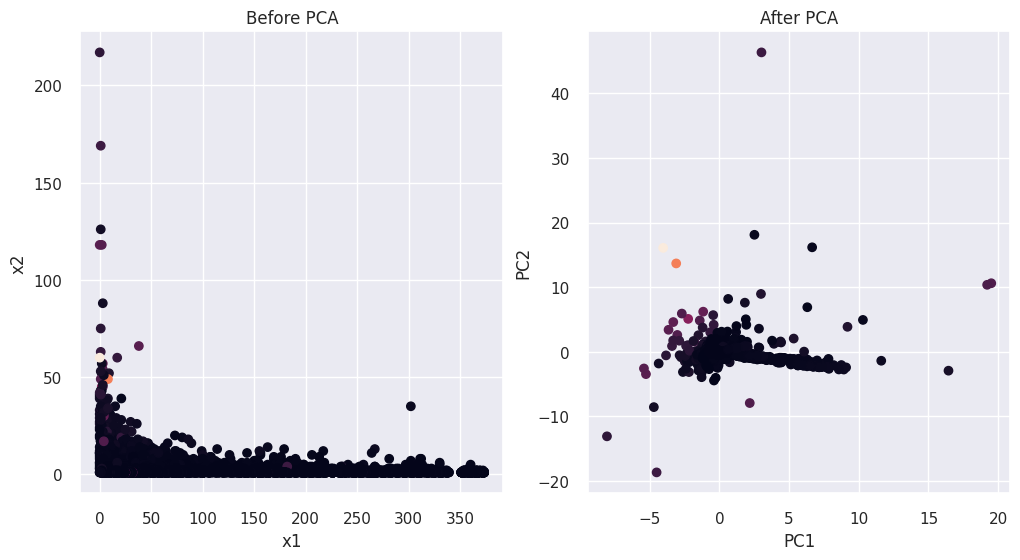

In [168]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(X_train.iloc[:, 1], X_train.iloc[:,2], c=X_train['monetary'])
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(x_new[:, 1], x_new[:, 2], c=X_train['monetary'])
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

## 5.3 Final Configuration

In [76]:
best_result_columns = ['scaler', 'dim_reduction', 'n_components', 'model', 'n_clusters/eps', 'silhouette', 'calinski_harabasz', 'davies_bouldin']
best_result_values = ['RobustScaler', 'PCA', '6', 'KMeans(n_clusters=5, n_init=20, random_state=42)', '5.00', '0.67', '1479.89', '1.64']
best_result_values_2 = ['RobustScaler', 'PCA', '7', 'KMeans(n_clusters=5, n_init=20, random_state=42)', '5.00', '0.67', '1440.64', '1.60']
best_result_df = pd.DataFrame(columns=best_result_columns, data=[best_result_values])

In [84]:
best_result_df

,scaler,dim_reduction,n_components,model,n_clusters/eps,silhouette,calinski_harabasz,davies_bouldin
0,RobustScaler,PCA,6,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.67,1479.89,1.64


In [ ]:
# Step 1: Dynamically select and apply scaler
scaler_class = best_result_df['scaler'][0]  # 'RobustScaler'
scaler = eval(scaler_class + '()')  # Equivalent to RobustScaler()
X_scaled = scaler.fit_transform(X_train)

In [ ]:
# Step 2: Dynamically select and apply dimensionality reduction
dim_reduction_class = best_result_df['dim_reduction'][0]  # 'PCA'
n_components = int(best_result_df['n_components'][0])
dim_reduction = eval(dim_reduction_class + f'(n_components={n_components})')  # Equivalent to PCA(n_components=6)
X_reduced = dim_reduction.fit_transform(X_scaled)

# Step 3: Dynamically select and train clustering model
model_code = best_result_df['model'][0]  # "KMeans(n_clusters=5, n_init=20, random_state=42)"
clustering_model = eval(model_code)  # Equivalent to KMeans(...)
clustering_model.fit(X_reduced)

# Output
print("Final clustering model trained successfully!")
print(f"Cluster Centers Shape: {clustering_model.cluster_centers_.shape}" if hasattr(clustering_model, "cluster_centers_") else "No cluster centers (DBSCAN)")

# Predict cluster labels
cluster_labels = clustering_model.fit_predict(X_reduced)
print(f"Cluster Labels: {np.unique(cluster_labels)}")

In [ ]:
X_reducted   = eval(best_result_df['dim_reduction'] + '()').fit_transform(X_scaled)
model_final  = eval(best_result_df['model'][0])
final_labels = model_final.fit_predict(X_reducted)

idx_order = np.argsort(model_final.means_.sum(axis=1))
print(idx_order)
df_final = X.copy()
df_final['cluster'] = final_labels

In [86]:
y=X['monetary']

In [106]:
def gen_cluster(X: pd.DataFrame, X_train: pd.DataFrame, y: pd.Series, best_result: pd.DataFrame):
    X_scaled     = eval(best_result_df['scaler'][0] + '()').fit_transform(X_train)
    X_reducted   = eval(best_result_df['dim_reduction'][0] + '()').fit_transform(X_scaled)
    model_final  = eval(best_result_df['model'][0])
    final_labels = model_final.fit_predict(X_reducted)

    # try:
    #     idx_order = np.argsort(model_final.means_.sum(axis=1))
    # except AttributeError:
    #     'Wrong Model'
    # else:
    #     idx_order = np.argsort(model_final.cluster_centers_.sum(axis=1))

    
    df_final = X.copy()
    df_final['cluster'] = final_labels
    
    return df_final

In [116]:
df_final = gen_cluster(X, X_train, y, best_result_df)

## 5.8 Gera Relatorio

In [119]:
X.head(1)

,customer_id,monetary,recency,frequency,qtde_items,qtde_products,avg_ticket,avg_basket_size,avg_unique_basket_size
0,17850,"5,288.63",302,35,1693,312,16.95,48.37,0.69


In [143]:
def report_cluster(df_final):

    pd.options.display.float_format = '{:,.2f}'.format

    df_cluster_aux = df_final.groupby('cluster', as_index = False).agg( 
                                                    total_customers = ('customer_id', 'count'),
                                                    avg_recency = ('recency', 'mean'),
                                                    avg_frequency = ('frequency', 'mean'),
                                                    avg_monetary = ('monetary', 'mean'),
                                                    avg_total_items = ('qtde_products', 'mean'),
                                        )

    df_cluster_aux['pct_customers'] = (df_cluster_aux['total_customers'] / df_cluster_aux['total_customers'].sum()) * 100
    df_cluster_aux = df_cluster_aux[['cluster', 'total_customers', 'pct_customers', 'avg_recency', 'avg_frequency', 'avg_monetary', 'avg_total_items']]
    df_cluster_aux = df_cluster_aux.sort_values(by='avg_monetary', ascending=False)
    best_cluster = np.argmax(df_cluster_aux['avg_monetary'])
    
    return df_cluster_aux, best_cluster    

In [144]:
df_clusters, best_cluster = report_cluster(df_final)

In [145]:
df_clusters

,cluster,total_customers,pct_customers,avg_recency,avg_frequency,avg_monetary,avg_total_items
3,3,28,0.53,7.71,54.39,"58,172.01","1,108.93"
1,1,1,0.02,182.00,4.00,"39,619.50",4.00
2,2,5,0.09,90.40,2.40,"9,527.08",6.00
4,4,299,5.63,167.26,1.00,"2,868.75",307.10
0,0,4982,93.73,116.31,3.84,"1,148.38",73.91


# 6.0 Kedro Pipeline

1. DATA INGESTION
1. DATA PREPROCESSING 
    1. WRANGLING 
        - renaming
        - replacing NAs (cria ids de clientes para faturas que não o continham)
        - drop NAs (registros sem description)
    2. CHANGING DTYPES
        - parse data, customer_id para int
    3. DROP DUPLICATES
        - drop customer_ids duplicados
2. FEATURE FILTERING
    1. NUMERICAL COLS
        - unit_price > 0.04
    2. CATEGORICAL COLS
        - remove:
            - stock_code estranhos
            - description column (not necessary)
            - filter ONLY UK country
            - bad users (after Univariate Analysis)
            - negative Quantity numbers (df_purchases & df_returns)
            
3. FEATURE ENGINEERING
    1. RFM
    2. BUSINESS FEATURES

4. PIPELINE: FEATURE NORMALIZATION & SPACE CREATION & MODEL SELECTION

5. FINAL MODEL & CLUSTER ASSIGNMENT


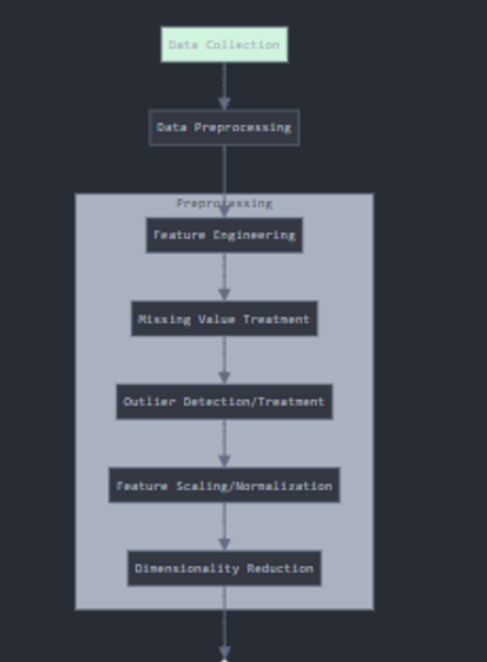

## 6.1 Data Ingestion

In [ ]:
import pandas as pd
from typing import Optional, Union, Literal
from pathlib import Path


def data_ingestion(
    file_path: Union[str, Path], 
    file_type: Optional[Literal["csv", "excel", "parquet"]] = None,
    **kwargs) -> pd.DataFrame:
    """
    Reads data from the specified file path and returns it as a pandas DataFrame.
    
    Args:
        file_path (Union[str, Path]): Path to the data file.
        file_type (Optional[Literal["csv", "excel", "parquet"]]): Type of file to read.
            If None, will be inferred from file extension.
        **kwargs: Additional arguments to pass to the pandas read function.
            
    Returns:
        pd.DataFrame: The loaded data as a pandas DataFrame.
        
    Raises:
        ValueError: If the file type is not supported or cannot be inferred.
        FileNotFoundError: If the specified file does not exist.
    """
    # Convert string path to Path object for more robust handling
    path = Path(file_path) if isinstance(file_path, str) else file_path
    
    # Check if file exists
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    
    # Determine file type if not explicitly provided
    if file_type is None:
        suffix = path.suffix.lower()
        if suffix in ['.csv', '.txt']:
            file_type = 'csv'
        elif suffix in ['.xlsx', '.xls']:
            file_type = 'excel'
        elif suffix == '.parquet':
            file_type = 'parquet'
        else:
            raise ValueError(f"Could not infer file type from extension: {suffix}")
    
    # Read data based on file type
    if file_type == 'csv':
        return pd.read_csv(path, **kwargs)
    elif file_type == 'excel':
        return pd.read_excel(path, **kwargs)
    elif file_type == 'parquet':
        return pd.read_parquet(path, **kwargs)
    else:
        raise ValueError(f"Unsupported file type: {file_type}")

## 6.2 Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, Optional, Union, Tuple, List, Literal

def data_preprocessing(
    df_raw: pd.DataFrame,
    drop_columns: Optional[List[str]] = None,
    new_column_names: Optional[List[str]] = None,
    missing_id_start: int = 19000,
    date_format: str = '%d-%b-%y'
) -> pd.DataFrame:
    """
    Preprocesses raw e-commerce data by cleaning, transforming, and standardizing it.
    
    Args:
        df_raw (pd.DataFrame): Raw e-commerce data.
        drop_columns (Optional[List[str]]): Columns to drop. Defaults to ['Unnamed: 8'].
        new_column_names (Optional[List[str]]): New column names. Defaults to standard e-commerce column names.
        missing_id_start (int): Starting ID for customers with missing IDs. Defaults to 19000.
        date_format (str): Format string for date parsing. Defaults to '%d-%b-%y'.
        
    Returns:
        pd.DataFrame: Preprocessed reference dataframe containing only customer_id.
        
    Raises:
        ValueError: If required columns are missing from the dataframe.
    """
    # Make a copy to avoid modifying the original dataframe
    df = df_raw.copy()
    
    # Set default values if not provided
    if drop_columns is None:
        drop_columns = ['Unnamed: 8']
    
    if new_column_names is None:
        new_column_names = [
            'invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country'
        ]
    
    # Drop unwanted columns if they exist
    columns_to_drop = [col for col in drop_columns if col in df.columns]
    if columns_to_drop:
        df.drop(columns=columns_to_drop, axis=1, inplace=True)
    
    # Validate column count matches expected names
    if len(df.columns) != len(new_column_names):
        raise ValueError(f"DataFrame has {len(df.columns)} columns but {len(new_column_names)} names were provided")
    
    # Rename columns
    df.columns = new_column_names
    
    # Handle missing customer IDs
    df_missing = df.loc[df['customer_id'].isna(), :]
    
    # Create reference dataframe for missing IDs
    df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
    df_backup['customer_id'] = np.arange(
        missing_id_start, 
        missing_id_start + len(df_backup), 
        1
    )
    
    # Merge original with reference dataframe
    df2 = pd.merge(df, df_backup, on='invoice_no', how='left')
    
    # Coalesce customer_id columns
    df2['customer_id'] = df2['customer_id_x'].combine_first(df2['customer_id_y'])
    
    # Drop extra columns
    df2.drop(columns=['customer_id_x', 'customer_id_y'], axis=1, inplace=True)
    
    # Drop rows with missing essential data
    df2.dropna(subset=['description', 'customer_id'], inplace=True)
    
    # Convert data types
    df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format=date_format, errors='coerce')
    df2['customer_id'] = df2['customer_id'].astype(int)
    
    # Create customer reference dataframe (only customer_id)
    df_ref = df2[['customer_id']].drop_duplicates(ignore_index=True)
    
    return df_ref

In [ ]:
def feature_filtering(
    df: pd.DataFrame,
    min_unit_price: float = 0.04,
    excluded_stock_codes: Optional[List[str]] = None,
    excluded_countries: Optional[List[str]] = None,
    excluded_customer_ids: Optional[List[int]] = None
) -> Dict[str, pd.DataFrame]:
    """
    Filters e-commerce data based on various criteria and splits into relevant subsets.
    
    Args:
        df (pd.DataFrame): Preprocessed e-commerce data.
        min_unit_price (float): Minimum unit price to include. Defaults to 0.04.
        excluded_stock_codes (Optional[List[str]]): Stock codes to exclude. 
            Defaults to a list of common non-product codes.
        excluded_countries (Optional[List[str]]): Countries to exclude.
            Defaults to ['European Community', 'Unspecified'].
        excluded_customer_ids (Optional[List[int]]): Customer IDs to exclude.
            Defaults to [16464].
            
    Returns:
        Dict[str, pd.DataFrame]: Dictionary containing:
            - 'filtered_data': Main filtered dataframe
            - 'returns': Dataframe with return transactions (negative quantities)
            - 'purchases': Dataframe with purchase transactions (positive quantities)
            
    Raises:
        ValueError: If required columns are missing from the dataframe.
    """
    # Make a copy to avoid modifying the original dataframe
    df_filtered = df.copy()
    
    # Set default values if not provided
    if excluded_stock_codes is None:
        excluded_stock_codes = [
            'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 
            'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'
        ]
    
    if excluded_countries is None:
        excluded_countries = ['European Community', 'Unspecified']
    
    if excluded_customer_ids is None:
        excluded_customer_ids = [16464]
    
    # Check for required columns
    required_columns = ['unit_price', 'stock_code', 'country', 'customer_id', 'quantity']
    missing_columns = [col for col in required_columns if col not in df_filtered.columns]
    if missing_columns:
        raise ValueError(f"Required columns missing: {missing_columns}")
    
    # Filter by unit price
    df_filtered = df_filtered.loc[df_filtered['unit_price'] > min_unit_price, :]
    
    # Filter by stock code
    df_filtered = df_filtered.loc[~df_filtered['stock_code'].isin(excluded_stock_codes), :]
    
    # Remove description column if it exists
    if 'description' in df_filtered.columns:
        df_filtered = df_filtered.drop(columns='description', axis=1)
    
    # Filter by country
    df_filtered = df_filtered[~df_filtered['country'].isin(excluded_countries)]
    
    # Filter out problematic customer IDs
    df_filtered = df_filtered[~df_filtered['customer_id'].isin(excluded_customer_ids)]
    
    # Split by transaction type (purchase vs return)
    df_returns = df_filtered.loc[df_filtered['quantity'] < 0, :].copy()
    df_purchases = df_filtered.loc[df_filtered['quantity'] > 0, :].copy()
    
    # Return results as a dictionary with meaningful names
    return {
        'filtered_data': df_filtered,
        'returns': df_returns,
        'purchases': df_purchases
    }

In [2]:
# # DEPRECATED

# def preprocess_ecommerce(Ecommerce: pd.DataFrame) -> pd.DataFrame:
#     """Preprocesses the data for Ecommerce.

#     Args:
#         Ecommerce: Raw data.
#     Returns:
#         Dataframe preprocessado.
#     """
    
#     # Dropping unwanted columns
#     Ecommerce.drop(columns=['Unnamed: 8'], axis=1, inplace=True)
    
#     # Rename columns
#     cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
#     Ecommerce.columns = cols_new
    
#     df_missing = Ecommerce.loc[Ecommerce['customer_id'].isna(), :]
#     df_not_missing = Ecommerce.loc[~Ecommerce['customer_id'].isna(), :]
    
#     # create reference
#     df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
#     df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)


#     # merge original with reference dataframe
#     df2 = pd.merge(Ecommerce, df_backup, on='invoice_no', how='left')
#     # coalesce
#     df2['customer_id'] = df2['customer_id_x'].combine_first(df2['customer_id_y'])
#     # drop extra columns
#     df2 = df2.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)
#     # drop na
#     df2.dropna(subset=['description', 'customer_id'], inplace=True)

#     # Change Dtypes
#     df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')
#     df2['customer_id'] = df2['customer_id'].astype(int)

#     # Create DataFrame Reference
#     df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
#                     'quantity', 'invoice_date', 'unit_price', 
#                     'country'], axis=1).drop_duplicates(ignore_index=True)
    
#     return df_ref


# def feature_filtering(df_ref: pd.DataFrame) -> pd.DataFrame:    
#     """Filter features from the data.

#     Args:
#         df_ref: Reference data processed.
#     Returns:
#         Dataframe preprocessado.
#     """
#     ###### Numerical Cols ######
#     df_ref = df_ref.loc[df_ref['unit_price'] > 0.04, :]
#     ###### Categorical Cols ######
#     df_ref = df_ref.loc[~df_ref['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


#     # Description
#     df_ref = df_ref.drop(columns='description', axis=1)

#     # Map
#     df_ref = df_ref[~df_ref['country'].isin(['European Community', 'Unspecified'])]

#     # Bad Users - Atualizado após Análise Univariada
#     df_filtered = df_ref[~df_ref['customer_id'].isin([16464])]

#     # Quantity - negative numbers means product returns
#     df_returns = df_ref.loc[df_ref['quantity'] < 0, :]
#     df_purchases = df_ref.loc[df_ref['quantity'] > 0, :]
    

    
#     # When returning many variables, it is a good practice to give them names
#     return dict(
#         filtered_Ecommerce = df_filtered,
#         returns = df_returns,
#         purchases = df_purchases
#         )
# # Aqui eu termino a seção "3.0 - Feature Filtering", retorno o DF principal (df_filtered) 
# # e tb retorno os df returns e purchases, que serão utilizados na seção "4.0 - Feature Engineering"

## 6.3 Feature Engineering

In [ ]:


def feature_filtering(df: pd.DataFrame) -> pd.DataFrame:

    df = df.loc[df['unit_price'] > 0.04, :]
    df = df.loc[~df['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]
    df = df.drop(columns='description', axis=1)
    df = df[df['country'].isin(['United Kingdom'])]
    df = df[~df['customer_id'].isin([16464])]
    
    return df


In [37]:
def create_features(df):
    """
    Adds features to train set.   
    """
    
    df_ref = df.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)    
    
    # Gross Revenue (Faturamento = Quantidade * Preço)
    df['gross_revenue'] = df['quantity'] * df['unit_price']
    # Monetary
    df_monetary = df.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index().copy()
    
    
    # Recency: Dia da última compra
    df_recency = df.groupby('customer_id')['invoice_date'].max().reset_index()
    df_recency['recency'] = (df['invoice_date'].max() - df_recency['invoice_date']).dt.days
    df_recency = df_recency[['customer_id', 'recency']].copy()
    
    
    # Frequency - Contagem do número de compras feitas pelo cliente
    df_freq = (df[['customer_id', 'invoice_no']].drop_duplicates()
                                                          .groupby('customer_id')
                                                          .count()
                                                          .reset_index()
                                                          .astype(int)
                                                          .rename(columns={'invoice_no':'frequency'}))
    
    # Freq Quantity items
    df_freq2 = (df[['customer_id', 'quantity']].groupby('customer_id').sum()
                                                    .reset_index()
                                                    .rename(columns={'quantity':'qtde_items'}))
    
    df_freq3 = (df[['customer_id', 'stock_code']].groupby('customer_id').count()
                                                .reset_index()
                                                .rename(columns={'stock_code':'qtde_products'}))
    
    # Avg Ticket - Ticket Médio
    df_avg_ticket = (df[['customer_id', 'gross_revenue']].groupby('customer_id')
                                                         .mean()
                                                         .reset_index()
                                                         .rename(columns={'gross_revenue':'avg_ticket'}))


    df_aux49 = (df.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id') \
                                                                              .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('quantity', 'sum')) \
                                                                              .reset_index())
    serie_49 = df_aux49['n_products'] / df_aux49['n_purchase']
    df_aux49['avg_basket_size'] = serie_49

    df_aux410 = (df.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id') \
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('stock_code', 'nunique')) \
                                                                          .reset_index())
    serie_410 = df_aux410['n_products'] / df_aux410['n_purchase']
    df_aux410['avg_unique_basket_size'] = serie_410

    
    df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_freq2, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_freq3, how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
    df_ref = pd.merge(df_ref, df_aux49[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
    df_ref = pd.merge(df_ref, df_aux410[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
    
    df_ref.rename(columns={'gross_revenue':'monetary',
    #                'invoice_no':'quantity'
                          },
                    inplace=True)
    
    
    return df_ref

## 6.4 Model Training

In [ ]:
def split_train(df):
    X = df.copy()
    X_train = X.drop(columns='customer_id', axis=1)    
    
    return X_train

In [39]:
class TreeBasedEmbedding(BaseEstimator, TransformerMixin):
    """
    Custom transformer that uses Random Forest's apply method to create tree-based embeddings.
    This always will only use 2 components.
    """
    def __init__(self, n_components=2, n_estimators=100, random_state=42):
        self.n_components = 2  # Hardcoded to 2 as per your original implementation
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.rf = None
        
    def fit(self, X, y=None):
        # Validate y
        if y is None:
            raise ValueError("A target variable is required for fitting")
        
        # Ensure y is a Series or can be converted to one
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        
        # Handle DataFrame or numpy array input
        if isinstance(X, pd.DataFrame):
            X_features = X.drop(columns=[y.name])
        else:
            X_features = X
        
        # Train a RandomForestRegressor
        self.rf = RandomForestRegressor(
            n_estimators=self.n_estimators,
            random_state=self.random_state
        )
        self.rf.fit(X_features, y)
        return self
    
    def transform(self, X):
        # Get leaf indices for each sample across all trees
        if self.rf is None:
            raise ValueError("Transformer not fitted. Call fit before transform.")
        
        # Handle DataFrame or numpy array input
        if isinstance(X, pd.DataFrame):
            X_features = X.values
        else:
            X_features = X
        
        leaf_indices = self.rf.apply(X_features)
        return leaf_indices
    
    def fit_transform(self, X, y):
        # Validate y
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        
        # Handle DataFrame or numpy array input
        if isinstance(X, pd.DataFrame):
            X_features = X.drop(columns=[y.name])
        else:
            X_features = X
        
        # Train a RandomForestRegressor
        self.rf = RandomForestRegressor(
            n_estimators=self.n_estimators,
            random_state=self.random_state
        )
        self.rf.fit(X_features, y)
        
        leaf_indices = self.rf.apply(X_features)
        return leaf_indices
    


def making_preds(X, y, component_range, cluster_range, eps_range, n_estimators=100):
    results = []
    best_pipeline = None
    best_score = -np.inf
    best_params = None

    scalers = {
        "StandardScaler": StandardScaler(),
        "MinMaxScaler": MinMaxScaler(),
        "RobustScaler": RobustScaler(),
    }
    
    reductors = {
        'PCA': PCA,  
        'UMAP': umap.UMAP, 
        'TreeBasedEmbedding': TreeBasedEmbedding, 
    }
    
    metrics = {
        "Silhouette Score": silhouette_score,
        "Calinski Harabasz Score": calinski_harabasz_score,
        "Davies Bouldin Score": davies_bouldin_score,
    }
    
    # Main loop
    for scaler_name, scaler in tqdm(scalers.items(), desc="Scalers"):
        for red_name, reductor in tqdm(reductors.items()):
            for model_name in tqdm(['DBSCAN', 'K-Means', 'Hierarchical', 'Gaussian Mixture']):
                if model_name == 'DBSCAN':
                    for component in component_range:
                        X_scaled = scaler.fit_transform(X)
                        
                        # Properly instantiate reductor
                        if red_name != 'TreeBasedEmbedding':
                            X_pca = reductor(n_components=component, random_state=42).fit_transform(X_scaled)
                        else:
                            X_leaf = reductor(n_estimators=n_estimators).fit_transform(X, y)
                            X_pca = PCA(n_components=2).fit_transform(X_leaf)
                        
                        for eps_val in eps_range:
                            model = DBSCAN(eps=eps_val, min_samples=20)
                            labels = model.fit_predict(X_pca)

                            # Calculate only if at least 5 clusters exist, removing noise
                            unique_labels = np.unique(labels)
                            unique_labels = unique_labels[unique_labels != -1]

                            if len(unique_labels) >= 5:
                                sil = silhouette_score(X, labels)
                                ch = calinski_harabasz_score(X, labels)
                                db = davies_bouldin_score(X, labels)

                                # Store results
                                results.append({
                                    'scaler': scaler_name,
                                    'dim_reduction': red_name,
                                    'n_components': component,
                                    'model': model,
                                    'n_clusters/eps': eps_val,
                                    'silhouette': sil,
                                    'calinski_harabasz': ch,
                                    'davies_bouldin': db,
#                                     'labels': labels
                                })
                else:
                    for component in component_range:
                        X_scaled = scaler.fit_transform(X)
                        
                        # Properly instantiate reductor
                        if red_name != 'TreeBasedEmbedding':
                            X_pca = reductor(n_components=component, random_state=42).fit_transform(X_scaled)
                        else:
                            X_leaf = reductor(n_estimators=n_estimators).fit_transform(X, y)
                            X_pca = PCA(n_components=2).fit_transform(X_leaf)
                        
                        for cluster in cluster_range:
                            if model_name == 'K-Means':
                                model = KMeans(n_clusters=cluster, random_state=42, n_init=20)
                            elif model_name == 'Hierarchical':
                                model = AgglomerativeClustering(n_clusters=cluster)
                            elif model_name == 'Gaussian Mixture':
                                model = GaussianMixture(n_components=cluster, random_state=42)
                            
                            labels = model.fit_predict(X_pca)
                            sil = silhouette_score(X, labels)
                            ch = calinski_harabasz_score(X, labels)
                            db = davies_bouldin_score(X, labels)
                            
                            results.append({
                                'scaler': scaler_name,
                                'dim_reduction': red_name,
                                'n_components': component,
                                'model': model,
                                'n_clusters/eps': cluster,
                                'silhouette': sil,
                                'calinski_harabasz': ch,
                                'davies_bouldin': db,
#                                 'labels': labels
                            })
                            
    results_no_pipeline = [{k: v for k, v in r.items() if k != 'pipeline' and k != 'labels'} for r in results]
    results_pd = pd.DataFrame(results_no_pipeline)
    best_result = results_pd.sort_values(['silhouette', 'calinski_harabasz', 'davies_bouldin'], ascending=[False, False, False])[0]
    return pd.DataFrame(results_no_pipeline)

In [40]:
comp_range = np.arange(2, 9)
clust_range = np.arange(5, 11)
eps_range = np.arange(0.2, 1.0, 0.1)

In [196]:
%%time

final_preds = making_preds(X=X_train, y=y, component_range=comp_range, cluster_range=clust_range, eps_range=eps_range)

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████▎                                                               | 1/4 [00:06<00:20,  6.72s/it]

 50%|██████████████████████████████████████████▌                                          | 2/4 [01:12<01:23, 41.62s/it]

 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [01:45<00:37, 37.47s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:19<00:00, 34.88s/it]

 33%|████████████████████████████                                                        | 1/3 [02:19<04:39, 139.50s/it]

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]

 25%|███████████████████

CPU times: user 1h 6min 25s, sys: 1h 8min 19s, total: 2h 14min 44s
Wall time: 25min 55s


## 6.5 Model Predictions

In [201]:
results_no_pipeline = [{k: v for k, v in r.items() if k != 'pipeline' and k != 'labels'} for r in final_preds]
final_preds_df = pd.DataFrame(results_no_pipeline)

In [208]:
final_preds_df.sort_values(['silhouette', 'calinski_harabasz', 'davies_bouldin'], ascending=[False, False, False]).head()

,scaler,dim_reduction,n_components,model,n_clusters/eps,silhouette,calinski_harabasz,davies_bouldin
872,RobustScaler,PCA,6,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.67,1446.53,1.57
848,RobustScaler,PCA,2,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.67,1440.64,1.60
878,RobustScaler,PCA,7,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.67,1479.89,1.64
850,RobustScaler,PCA,2,"KMeans(n_clusters=7, n_init=20, random_state=42)",7.00,0.64,5835.54,1.17
6,StandardScaler,PCA,3,"KMeans(n_clusters=5, n_init=20, random_state=42)",5.00,0.57,1767.84,1.34


## 6.6 Clusters Assignment

In [106]:
def gen_cluster(X: pd.DataFrame, X_train: pd.DataFrame, y: pd.Series, best_result: pd.DataFrame) -> pd.DataFrame:
    X_scaled     = eval(best_result_df['scaler'][0] + '()').fit_transform(X_train)
    X_reducted   = eval(best_result_df['dim_reduction'][0] + '()').fit_transform(X_scaled)
    model_final  = eval(best_result_df['model'][0])
    final_labels = model_final.fit_predict(X_reducted)

    # try:
    #     idx_order = np.argsort(model_final.means_.sum(axis=1))
    # except AttributeError:
    #     'Wrong Model'
    # else:
    #     idx_order = np.argsort(model_final.cluster_centers_.sum(axis=1))

    
    df_final = X.copy()
    df_final['cluster'] = final_labels
    
    return df_final

In [116]:
df_final = gen_cluster(X, X_train, y, best_result_df)